# Group 1

Fabio Ceruti- Fabio Martino - Alex Lucchini - Jacopo Biggiogera

In this notebook we have a series of resuslts from the error analysis.
In paritcular, we analyse:
1. results from a boostrap analysis of the main models we ran so as to understand if there are significant perofrmance differences amongst models.
2. if there are significant differences amongst the distributions of the various heatmaps of the test pictures as predicted by each type of model (vanilla, masked, bbox and mixed model) 
3. Test if there are significant differences amongs the average RGB value between the correctly predicted and incorrectly predicted pictures for each species
4. Test if there are significant differences in the distributions for each color channel between correctly predicted and incorrectly predicted pictures


In [14]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display
from collections import defaultdict
import cv2
from sklearn.metrics import accuracy_score

## Importing the data

In [2]:
with open('test_results/transfer_vanilla_testresults.pickle', "rb") as f:
    vanilla = pickle.load(f)
vanilla.head()
mis = []
for true, pred in zip(vanilla['label'], vanilla['predicted_label']):
    if true == pred:
        mis.append(0)
    else:
        mis.append(1)
    
vanilla['misclassified'] = mis
vanilla['species'] = [i.split('/')[1] for i in vanilla['path']]
vanilla.head()

,path,label,predicted_label,heatmap,misclassified,species
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6,6,"[[0.0008592655, 0.05038577, 0.065030456, 0.061...",0,Pandion haliaetus
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10,10,"[[0.0, 0.0, 0.024067912, 0.055310313, 0.027530...",0,Spinus tristis
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5,5,"[[0.0, 0.0, 0.00077875954, 0.16589779, 0.0, 0....",0,Pachydiplax longipennis
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,10,"[[0.0, 0.0, 0.02851929, 0.041939244, 0.0269606...",1,Canis latrans
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11,11,"[[0.1844241, 0.0, 0.0, 0.01486361, 0.0, 0.4014...",0,Trachemys scripta elegans


In [3]:
with open('test_results/transfer_masked_testresults.pickle', "rb") as f:
    masked = pickle.load(f)

mis = []
for true, pred in zip(masked['label'], masked['predicted_label']):
    if true == pred:
        mis.append(0)
    else:
        mis.append(1)
    
masked['misclassified'] = mis
masked['species'] = [i.split('/')[1] for i in masked['path']]
masked.head()
masked.head()

,path,label,predicted_label,heatmap,misclassified,species
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014405...",0,Pandion haliaetus
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10,3,"[[0.13823768, 0.20100996, 0.12389179, 0.402431...",1,Spinus tristis
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5,5,"[[0.0, 0.075153865, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0,Pachydiplax longipennis
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,7,"[[0.40024322, 0.68828684, 0.36428413, 0.277177...",1,Canis latrans
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11,4,"[[0.0, 0.026558172, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",1,Trachemys scripta elegans


In [4]:
with open('test_results/transfer_bbcontent_testresults.pickle', "rb") as f:
    bbcontent = pickle.load(f)

mis = []
for true, pred in zip(bbcontent['label'], bbcontent['predicted_label']):
    if true == pred:
        mis.append(0)
    else:
        mis.append(1)
    
bbcontent['misclassified'] = mis
bbcontent['species'] = [i.split('/')[1] for i in bbcontent['path']]
bbcontent.head()
bbcontent.head()

,path,label,predicted_label,heatmap,misclassified,species
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.21096286, ...",0,Pandion haliaetus
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10,10,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",0,Spinus tristis
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5,5,"[[0.13527793, 0.024011567, 0.074567, 0.2230256...",0,Pachydiplax longipennis
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,8,"[[0.22132397, 0.014507692, 0.067461096, 0.0, 0...",1,Canis latrans
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11,10,"[[0.020542832, 0.27724352, 0.0937886, 0.0, 0.0...",1,Trachemys scripta elegans


In [5]:
with open('test_results/transfer_mixed_testresults.pickle', "rb") as f:
    mixed = pickle.load(f)

mis = []
for true, pred in zip(mixed['label'], mixed['predicted_label']):
    if true == pred:
        mis.append(0)
    else:
        mis.append(1)
    
mixed['misclassified'] = mis
mixed['species'] = [i.split('/')[1] for i in mixed['path']]
mixed.head()
mixed.head()

,path,label,predicted_label,heatmap,misclassified,species
0,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,6,6,"[[0.0, 0.012305062, 0.0, 0.0, 0.011540991, 0.0...",0,Pandion haliaetus
1,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,10,10,"[[0.18301305, 0.008253035, 0.0, 0.0, 0.0, 0.01...",0,Spinus tristis
2,Animals/Pachydiplax longipennis/c67ae3e186acb3...,5,5,"[[0.39867985, 0.5812954, 0.2858046, 0.17883147...",0,Pachydiplax longipennis
3,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,8,"[[0.056406904, 0.0, 0.0, 0.014294575, 0.244122...",1,Canis latrans
4,Animals/Trachemys scripta elegans/fa1dd0961941...,11,1,"[[0.0, 0.053880766, 0.06943142, 0.057734657, 0...",1,Trachemys scripta elegans


# Bootstrap Analysis

In [6]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
    #print(p)
    return p/samples, deltas

### Comparing model trained on Whole Pictures VS Masked 

In [7]:
p_value, deltas = bootstrap_sample(vanilla['predicted_label'].astype('int'), masked['predicted_label'].astype('int'), vanilla['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.5331513260530422 vs. 0.3264430577223089
p_value: 0.0, Statistical significance at 1%level: True


### Comparing differences between only Bboxes content VS Masked

In [8]:
p_value, deltas = bootstrap_sample(bbcontent['predicted_label'].astype('int'), masked['predicted_label'].astype('int'), vanilla['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.515600624024961 vs. 0.3264430577223089
p_value: 0.0, Statistical significance at 1%level: True


### Comparing differences between Whole Pictures VS Bboxes content

In [9]:
p_value, deltas = bootstrap_sample(vanilla['predicted_label'].astype('int'), bbcontent['predicted_label'].astype('int'), vanilla['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.5331513260530422 vs. 0.515600624024961
p_value: 0.052, Statistical significance at 1%level: False


### Comparing Whole Picture with Mixed model

In [10]:
p_value, deltas = bootstrap_sample(mixed['predicted_label'].astype('int'), vanilla['predicted_label'].astype('int'), vanilla['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.5635725429017161 vs. 0.5331513260530422
p_value: 0.001, Statistical significance at 1%level: True


### Comparing BBcontent with Mixed model

In [11]:
p_value, deltas = bootstrap_sample(mixed['predicted_label'].astype('int'), bbcontent['predicted_label'].astype('int'), vanilla['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.5635725429017161 vs. 0.515600624024961
p_value: 0.0, Statistical significance at 1%level: True


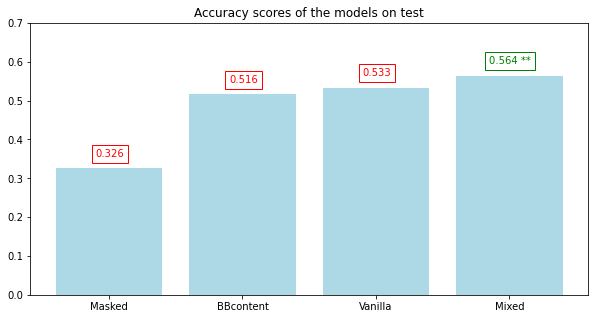

In [58]:
masked_acc = round(accuracy_score(masked['label'], masked['predicted_label']),3)
bbcontent_acc = round(accuracy_score(bbcontent['label'], bbcontent['predicted_label']),3)
mixed_acc = round(accuracy_score(mixed['label'], mixed['predicted_label']),3)
vanilla_acc = round(accuracy_score(vanilla['label'], vanilla['predicted_label']),3)

plt.figure(figsize = (10,5))
plt.bar(['Masked', 'BBcontent', 'Vanilla', 'Mixed'], [masked_acc, bbcontent_acc, vanilla_acc, mixed_acc], color = ['lightblue'])

plt.text(-0.1, masked_acc+0.03, f'{masked_acc}', color = 'red', bbox=dict(facecolor='none', edgecolor='red'))
plt.text(0.9, bbcontent_acc+0.03, f'{bbcontent_acc}', color = 'red', bbox=dict(facecolor='none', edgecolor='red'))
plt.text(1.9, vanilla_acc+0.03, f'{vanilla_acc}', color = 'red', bbox=dict(facecolor='none', edgecolor='red'))
plt.text(2.85, mixed_acc+0.03, f'{mixed_acc} **', color = 'green', bbox=dict(facecolor='none', edgecolor='green'))

plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
plt.title('Accuracy scores of the models on test')
plt.show()

Interestingly we find that while the model trained in the whole picture and just teh bbox content performs better than teh one trained on masked pictures, there are no significnat differences in the performance btween the former two (neither at the 1% nor at the 5% level). This might suggest that the model could be directly trained on more specific pictures that would be lighter in size. In addition, the model that is trained on the picture context (masked pictures) and teh bboxes content separately outperforms the model trained on the full picture. This is a very interesting result, suggesting that passing the picture in separate pices and allowing the network to learn which elements of teh context and of the animal separately is important to imporve its performance. It also provides fiurther support for the current techniques that more advanced model, such as VIT employ. (In the above model for simplicity we put the significnace sign only on the best performing model).

### Bootstrap on models predicting masked inputs

One of the potential applications we outlined i using models that are trained on masked pictures to be able to , once give the picture of an envionment without animals, predict more accurately what species could live in it. In order to test this hypotesis we also tested teh perofmrance of three of our models on predicting test pictures that have their animal masked. Specifically, we tested:

1. The model trained on masked pictures
2. The mixed model trained on the spearated masked pictures and bounding boxes
3. The vanilla model as control

#### Importing the relevant data

In [59]:
# Importing masked model data
with open('masked_test_results/masked_masked_test_results.pickle', "rb") as f:
    masked_masked = pickle.load(f)
    
with open('masked_test_results/mixed_masked_test_results.pickle', "rb") as f:
    mixed_masked = pickle.load(f)
    
with open('masked_test_results/vanilla_masked_test_results.pickle', "rb") as f:
    vanilla_masked= pickle.load(f)

#### Masked model VS Vanilla

In [60]:
p_value, deltas = bootstrap_sample(masked_masked['predicted_label'].astype('int'), vanilla_masked['predicted_label'].astype('int'), vanilla_masked['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.35842433697347886 vs. 0.2952418096723869
p_value: 0.0, Statistical significance at 1%level: True


#### Mixed model VS Vanilla

In [61]:
p_value, deltas = bootstrap_sample(mixed_masked['predicted_label'].astype('int'), vanilla_masked['predicted_label'].astype('int'), vanilla_masked['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.4001560062402496 vs. 0.2952418096723869
p_value: 0.0, Statistical significance at 1%level: True


#### Mixed model VS Masked model

In [62]:
p_value, deltas = bootstrap_sample(mixed_masked['predicted_label'].astype('int'), masked_masked['predicted_label'].astype('int'), vanilla_masked['label'].astype('int'))
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.01}')

Base difference: 0.4001560062402496 vs. 0.35842433697347886
p_value: 0.0, Statistical significance at 1%level: True


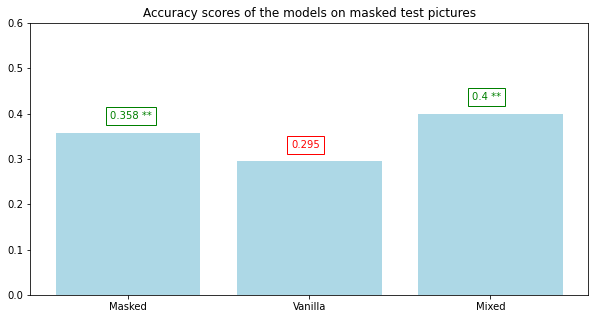

In [71]:
m_masked_acc = round(accuracy_score(masked_masked['label'], masked_masked['predicted_label']),3)
m_mixed_acc = round(accuracy_score(mixed_masked['label'], mixed_masked['predicted_label']),3)
m_vanilla_acc = round(accuracy_score(vanilla_masked['label'], vanilla_masked['predicted_label']),3)

plt.figure(figsize = (10,5))
plt.bar(['Masked', 'Vanilla', 'Mixed'], [m_masked_acc, m_vanilla_acc, m_mixed_acc], color = ['lightblue'])

plt.text(-0.1, m_masked_acc+0.03, f'{m_masked_acc} **', color = 'green', bbox=dict(facecolor='none', edgecolor='green'))
plt.text(0.9, m_vanilla_acc+0.03, f'{m_vanilla_acc}', color = 'red', bbox=dict(facecolor='none', edgecolor='red'))
plt.text(1.9, m_mixed_acc+0.03, f'{m_mixed_acc} **', color = 'green', bbox=dict(facecolor='none', edgecolor='green'))

plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
plt.title('Accuracy scores of the models on masked test pictures')
plt.show()

As expected we see that both the masked model and the mixed model perform better on this task than the vanilla since they had a more affine training. Interestingly, the model that performs the best though is the Mixed model, that is somehow able to benefit also form teh animal specific information that it gathers from the bounding boxes to achieve better predictions also on the masked test.

# Heatmap analysis

In [6]:
import matplotlib.cm as cm
from IPython.display import Image, display
def heatmap_adjuster(img_path, heatmap):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    return jet_heatmap

In [7]:
# Calculating errors between each heatmap and a matrix of ones
mse_masked = []
mse_bbcontent = []
mse_vanilla = []
mse_mixed = []

for ind, pic in tqdm(enumerate(vanilla['path'])):
    van = heatmap_adjuster(pic, vanilla['heatmap'][ind])
    mask = heatmap_adjuster(pic, masked['heatmap'][ind])
    bbcont = heatmap_adjuster(pic, bbcontent['heatmap'][ind])
    mix = heatmap_adjuster(pic, mixed['heatmap'][ind])
    ttf = np.ones(van.shape)*255
    mse_masked.append(np.sum((ttf-mask)))
    mse_bbcontent.append(np.sum((ttf-bbcont)))
    mse_vanilla.append(np.sum((ttf-van)))
    mse_mixed.append(np.sum((ttf-mix)))


2564it [06:06,  7.00it/s]


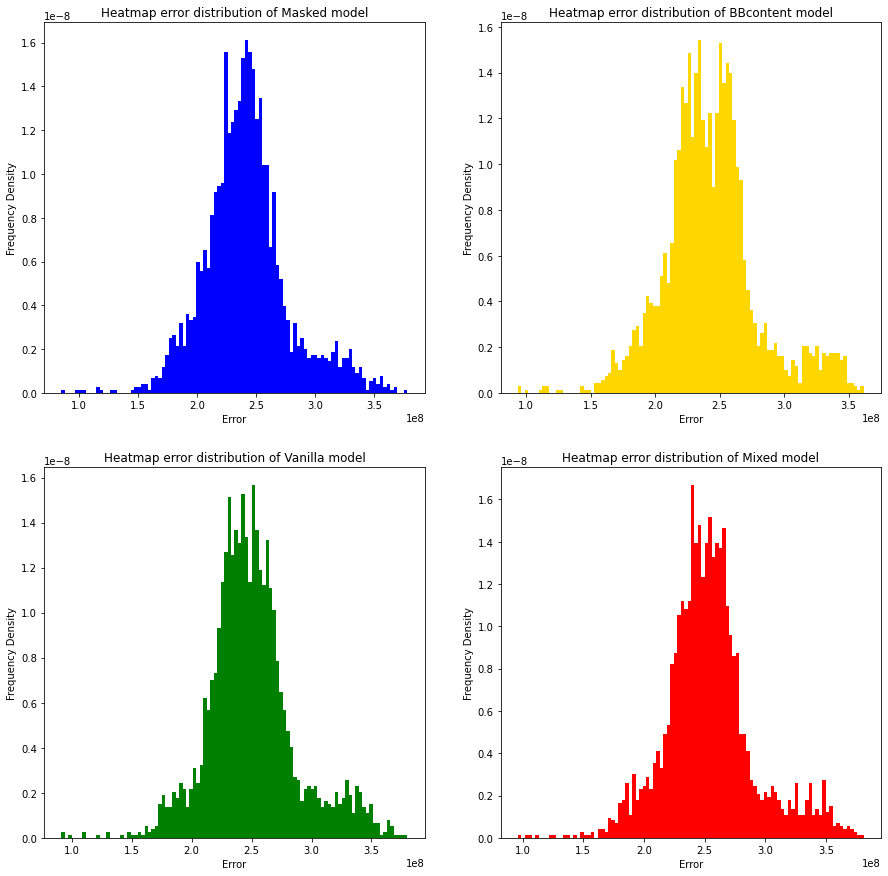

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
ax = axes.ravel()

ax[0].hist(mse_masked, bins = 100, density = True, color = 'blue', label = 'Masked')
ax[0].set_title('Heatmap error distribution of Masked model')
ax[0].set_xlabel('Error')
ax[0].set_ylabel('Frequency Density')

ax[1].hist(mse_bbcontent, bins = 100, density = True, color = 'gold', label = 'Bbcontent')
ax[1].set_title('Heatmap error distribution of BBcontent model')
ax[1].set_xlabel('Error')
ax[1].set_ylabel('Frequency Density')

ax[2].hist(mse_vanilla, bins = 100, density = True, color = 'green', label = 'Vanilla')
ax[2].set_title('Heatmap error distribution of Vanilla model')
ax[2].set_xlabel('Error')
ax[2].set_ylabel('Frequency Density')

ax[3].hist(mse_mixed, bins = 100, density = True, color = 'red', label = 'Mixed')
ax[3].set_title('Heatmap error distribution of Mixed model')
ax[3].set_xlabel('Error')
ax[3].set_ylabel('Frequency Density')
plt.show()

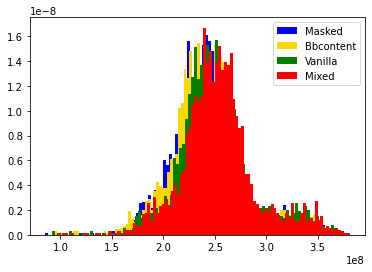

In [99]:
plt.hist(mse_masked, bins = 100, density = True, color = 'blue', label = 'Masked')
plt.hist(mse_bbcontent, bins = 100, density = True, color = 'gold', label = 'Bbcontent')
plt.hist(mse_vanilla, bins = 100, density = True, color = 'green', label = 'Vanilla')
plt.hist(mse_mixed, bins = 100, density = True, color = 'red', label = 'Mixed')
plt.legend()
plt.show()

In [16]:
from scipy.stats import kstest
kstest(mse_masked,mse_vanilla )

KstestResult(statistic=0.12012480499219969, pvalue=1.5743408338260276e-16)

In [17]:
kstest(mse_bbcontent,mse_vanilla )

KstestResult(statistic=0.10764430577223089, pvalue=2.3752626371936253e-13)

In [18]:
kstest(mse_bbcontent,mse_masked)

KstestResult(statistic=0.044851794071762874, pvalue=0.01149856130136341)

In [19]:
kstest(mse_vanilla,mse_mixed)

KstestResult(statistic=0.0717628705148206, pvalue=3.652872606909438e-06)

All heatmap error distribution are significantly different from each other, thus every network is looking at different things

# Color Histograms Analysis

## Average RGB values

In [67]:
# Defining utility functions
def generate_avgcolor_hist_dict(species, df):
    def_dict = defaultdict(list) 
    for spec in tqdm(species):
        counts_spec = np.zeros((255,))
        len_spec = 0
        for pic in df[df['species']==spec]['path']:
            im = cv2.imread(pic)
            # calculate mean value from RGB channels and flatten to 1D array
            vals = im.mean(axis=2).flatten()
            # calculate histogram
            counts, bins = np.histogram(vals, range(256))
            #append it to average counts
            counts_spec+=counts
            len_spec+=1
        #calculate average counts and add to right dictionary entry
        counts_spec/len_spec
        def_dict[spec] = counts_spec
    return def_dict, bins

def histogram_intersection(h1, h2):
    sm = 0
    mm = 0
    for i in range(len(h1)):
        sm += min(h1[i], h2[i])
        mm+=max(h1[i], h2[i])
    return sm/mm

In [68]:
# generating distributions for Vanilla network
species = set(vanilla['species'])
correct = vanilla[vanilla['misclassified']==0]
wrong = vanilla[vanilla['misclassified']==1]

correct_dist, bins = generate_avgcolor_hist_dict(species, correct)
incorrect_dist, bins = generate_avgcolor_hist_dict(species, wrong)

hist_int = defaultdict(float)
for spec in species:
    hist_int[spec]=histogram_intersection(correct_dist[spec], incorrect_dist[spec])

100%|██████████| 12/12 [00:52<00:00,  4.39s/it]


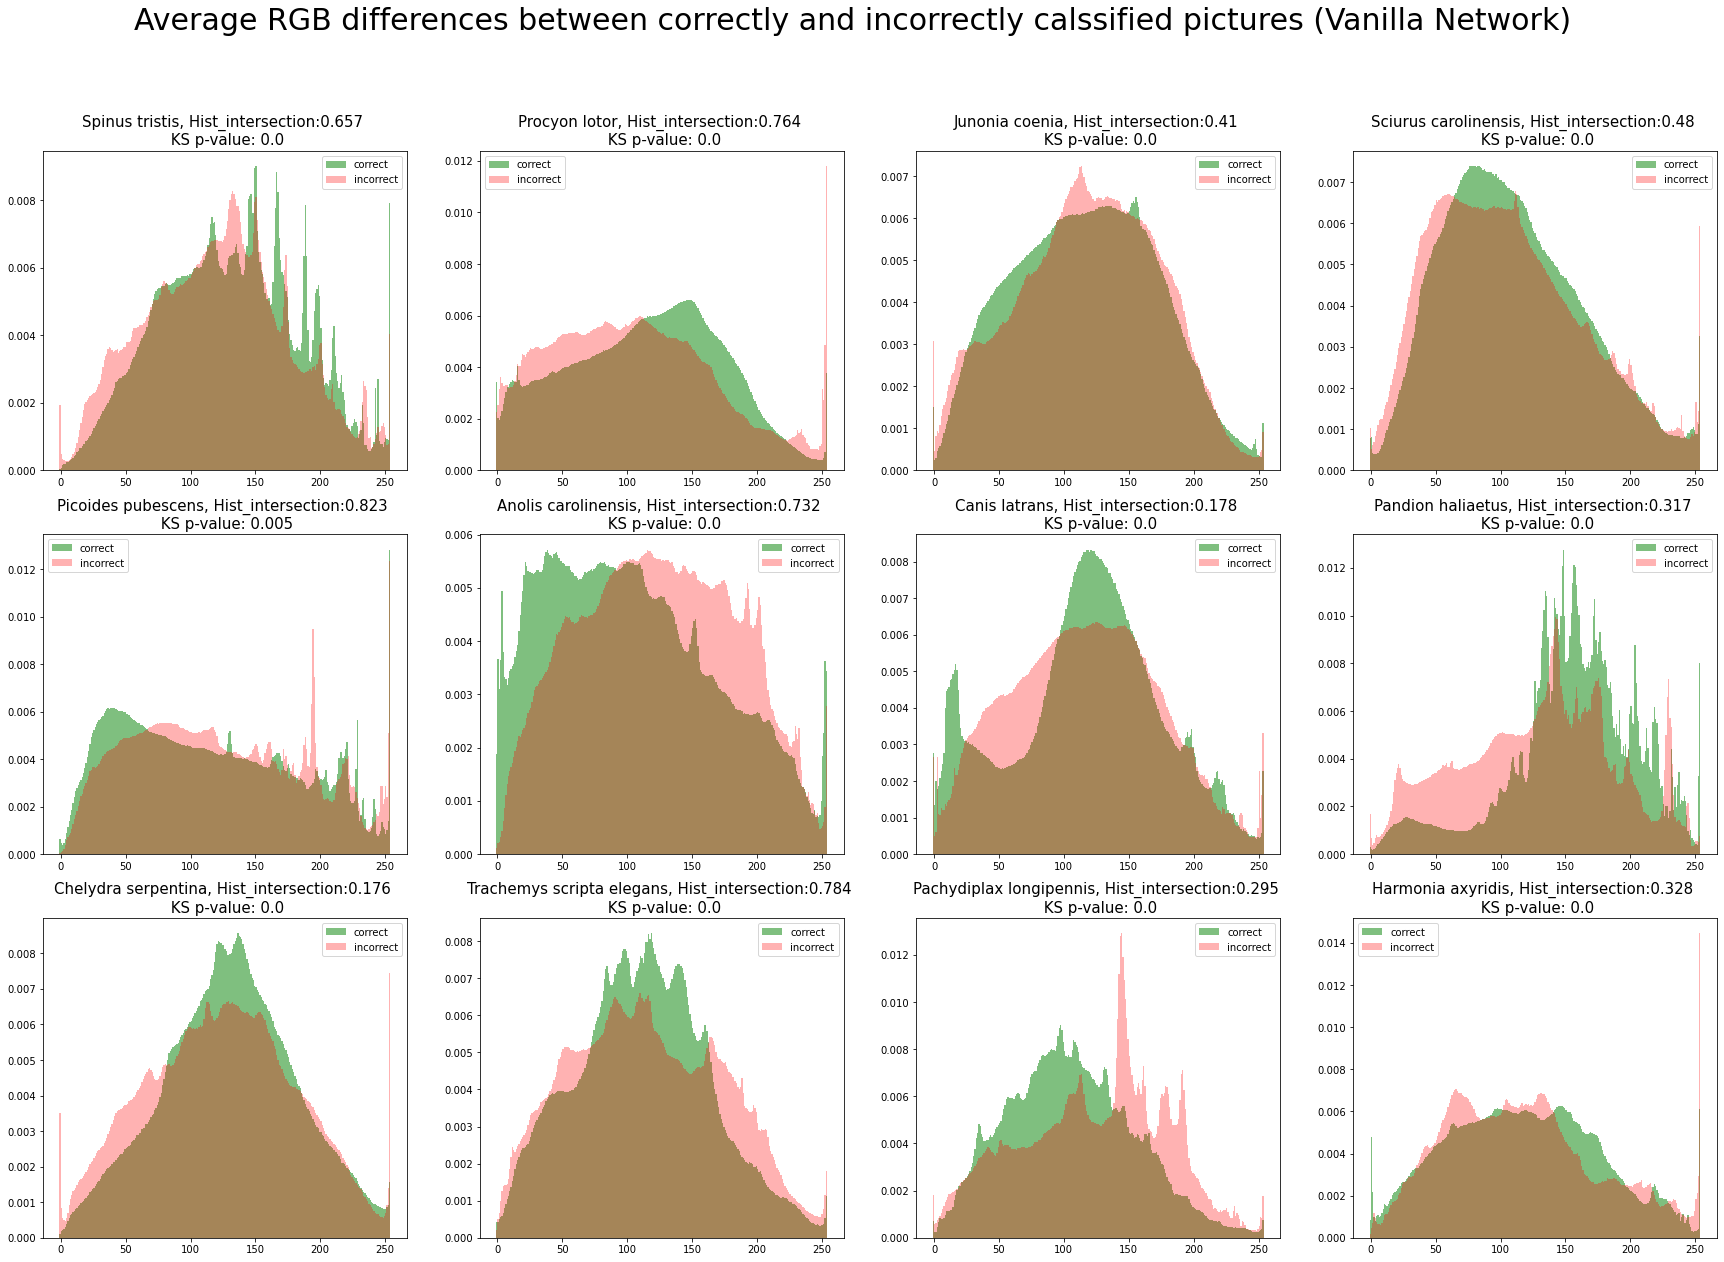

In [69]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize =(30,20))
axes = axes.ravel()
for ax, spec in zip(axes, species):
    ax.bar(bins[:-1] - 0.5, correct_dist[spec]/np.sum(correct_dist[spec]), width=1, color='green', label = 'correct', alpha = 0.5)
    ax.bar(bins[:-1] - 0.5, incorrect_dist[spec]/np.sum(incorrect_dist[spec]), width=1, color='red', label = 'incorrect', alpha = 0.3)
    kpval = round(kstest(correct_dist[spec],incorrect_dist[spec])[1], 3)
    ax.set_title(f'{spec}, Hist_intersection:{round(hist_int[spec], 3)} \n KS p-value: {kpval}', fontsize = 15)
    ax.legend()
    
fig.suptitle('Average RGB differences between correctly and incorrectly calssified pictures (Vanilla Network)', fontsize = 30)
plt.show()

In [70]:
# generating distributions for Masked network
species = set(masked['species'])
correct = masked[masked['misclassified']==0]
wrong = masked[masked['misclassified']==1]

correct_dist_m, bins = generate_avgcolor_hist_dict(species, correct)
incorrect_dist_m, bins = generate_avgcolor_hist_dict(species, wrong)

hist_int_m = defaultdict(float)
for spec in species:
    hist_int_m[spec]=histogram_intersection(correct_dist_m[spec], incorrect_dist_m[spec])

 67%|██████▋   | 8/12 [00:28<00:17,  4.39s/it]<ipython-input-67-ec04111e9f85>:17: RuntimeWarning: invalid value encountered in true_divide
  counts_spec/len_spec
100%|██████████| 12/12 [01:15<00:00,  6.27s/it]


<ipython-input-71-4f45dda845fb>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.bar(bins[:-1] - 0.5, correct_dist_m[spec]/np.sum(correct_dist_m[spec]), width=1, color='green', label = 'correct', alpha = 0.5)


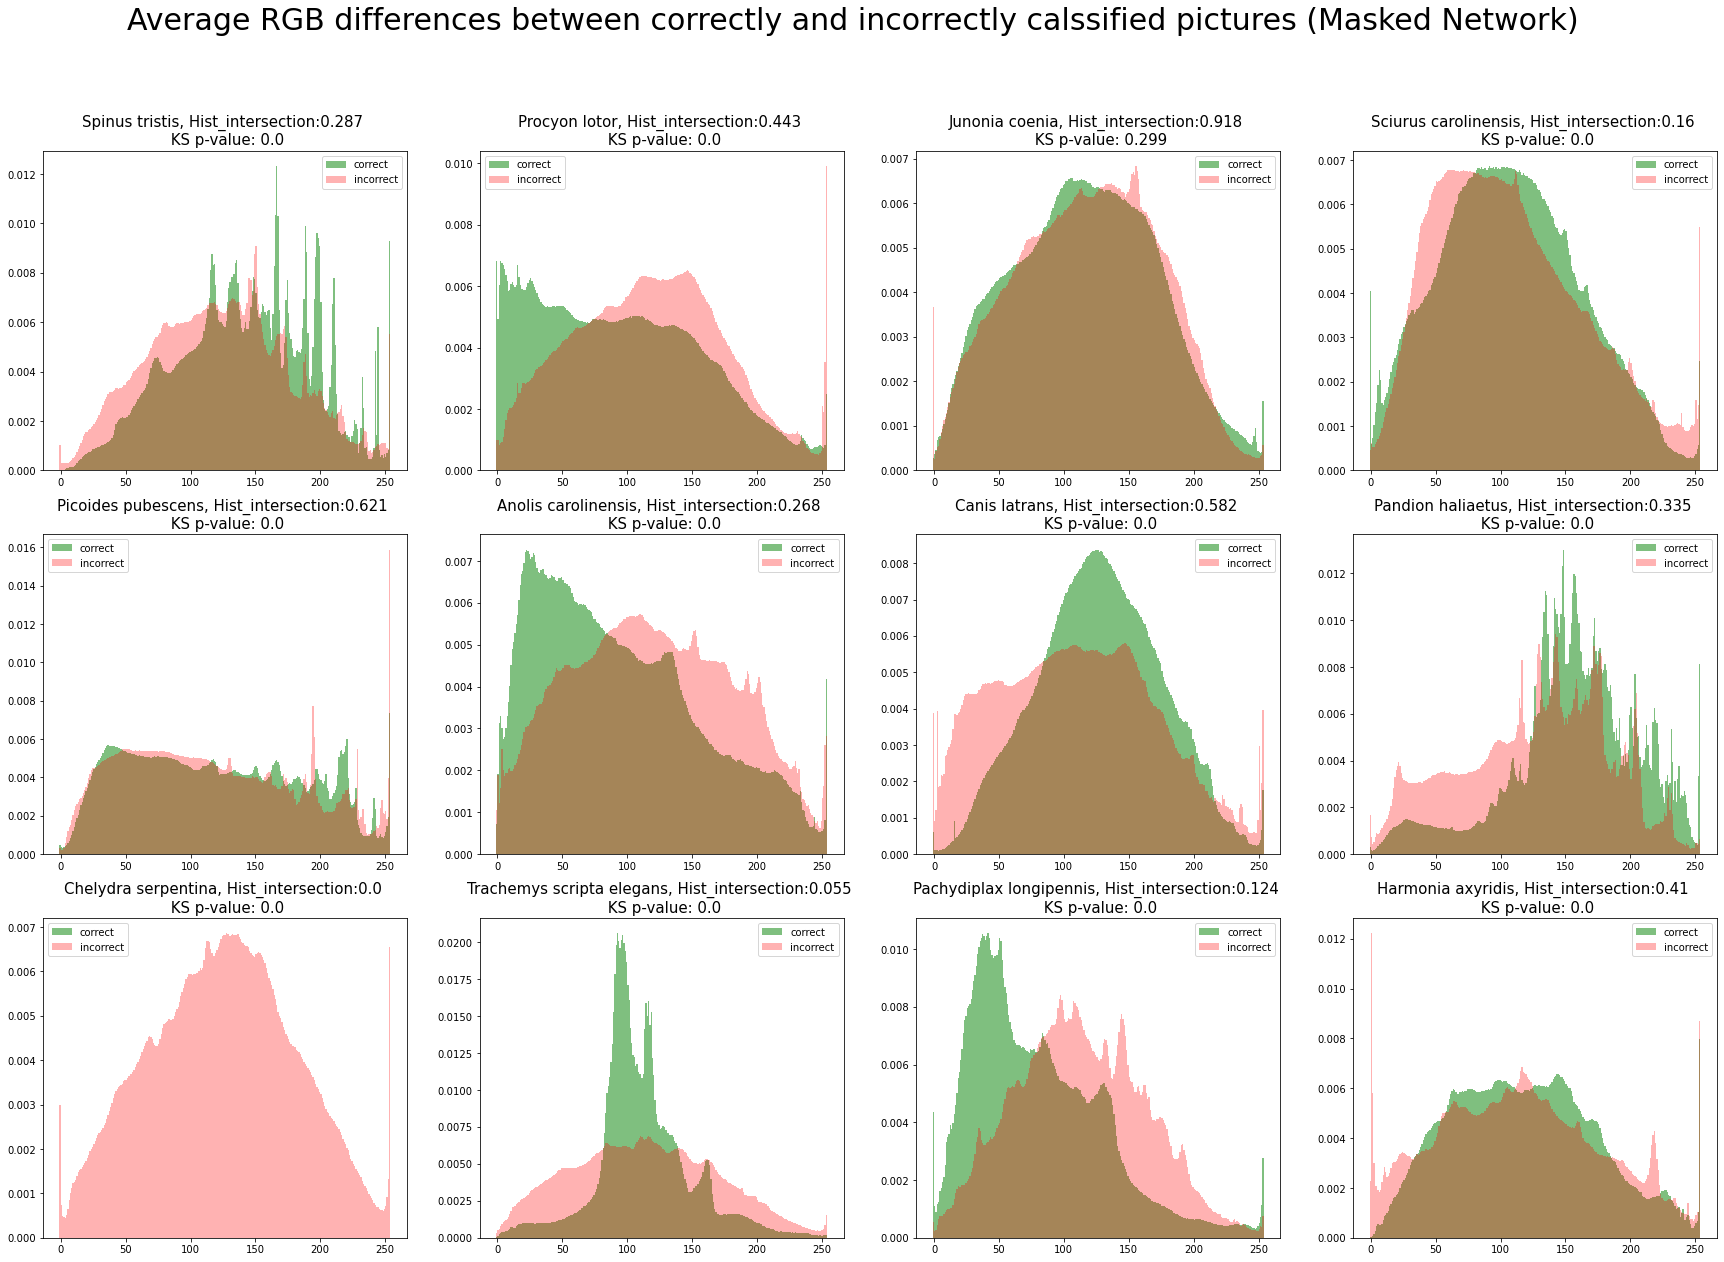

In [71]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize =(30,20))
axes = axes.ravel()
for ax, spec in zip(axes, species):
    ax.bar(bins[:-1] - 0.5, correct_dist_m[spec]/np.sum(correct_dist_m[spec]), width=1, color='green', label = 'correct', alpha = 0.5)
    ax.bar(bins[:-1] - 0.5, incorrect_dist_m[spec]/np.sum(incorrect_dist_m[spec]), width=1, color='red', label = 'incorrect', alpha = 0.3)
    kpval_m = round(kstest(correct_dist_m[spec],incorrect_dist_m[spec])[1], 3)
    ax.set_title(f'{spec}, Hist_intersection:{round(hist_int_m[spec], 3)} \n KS p-value: {kpval_m}', fontsize = 15)
    ax.legend()
    
fig.suptitle('Average RGB differences between correctly and incorrectly calssified pictures (Masked Network)', fontsize = 30)
plt.show()

In [72]:
# generating distributions for BBcontent network
species = set(bbcontent['species'])
correct = bbcontent[bbcontent['misclassified']==0]
wrong = bbcontent[bbcontent['misclassified']==1]

correct_dist_b, bins = generate_avgcolor_hist_dict(species, correct)
incorrect_dist_b, bins = generate_avgcolor_hist_dict(species, wrong)

hist_int_b = defaultdict(float)
for spec in species:
    hist_int_b[spec]=histogram_intersection(correct_dist_b[spec], incorrect_dist_b[spec])

100%|██████████| 12/12 [00:54<00:00,  4.52s/it]


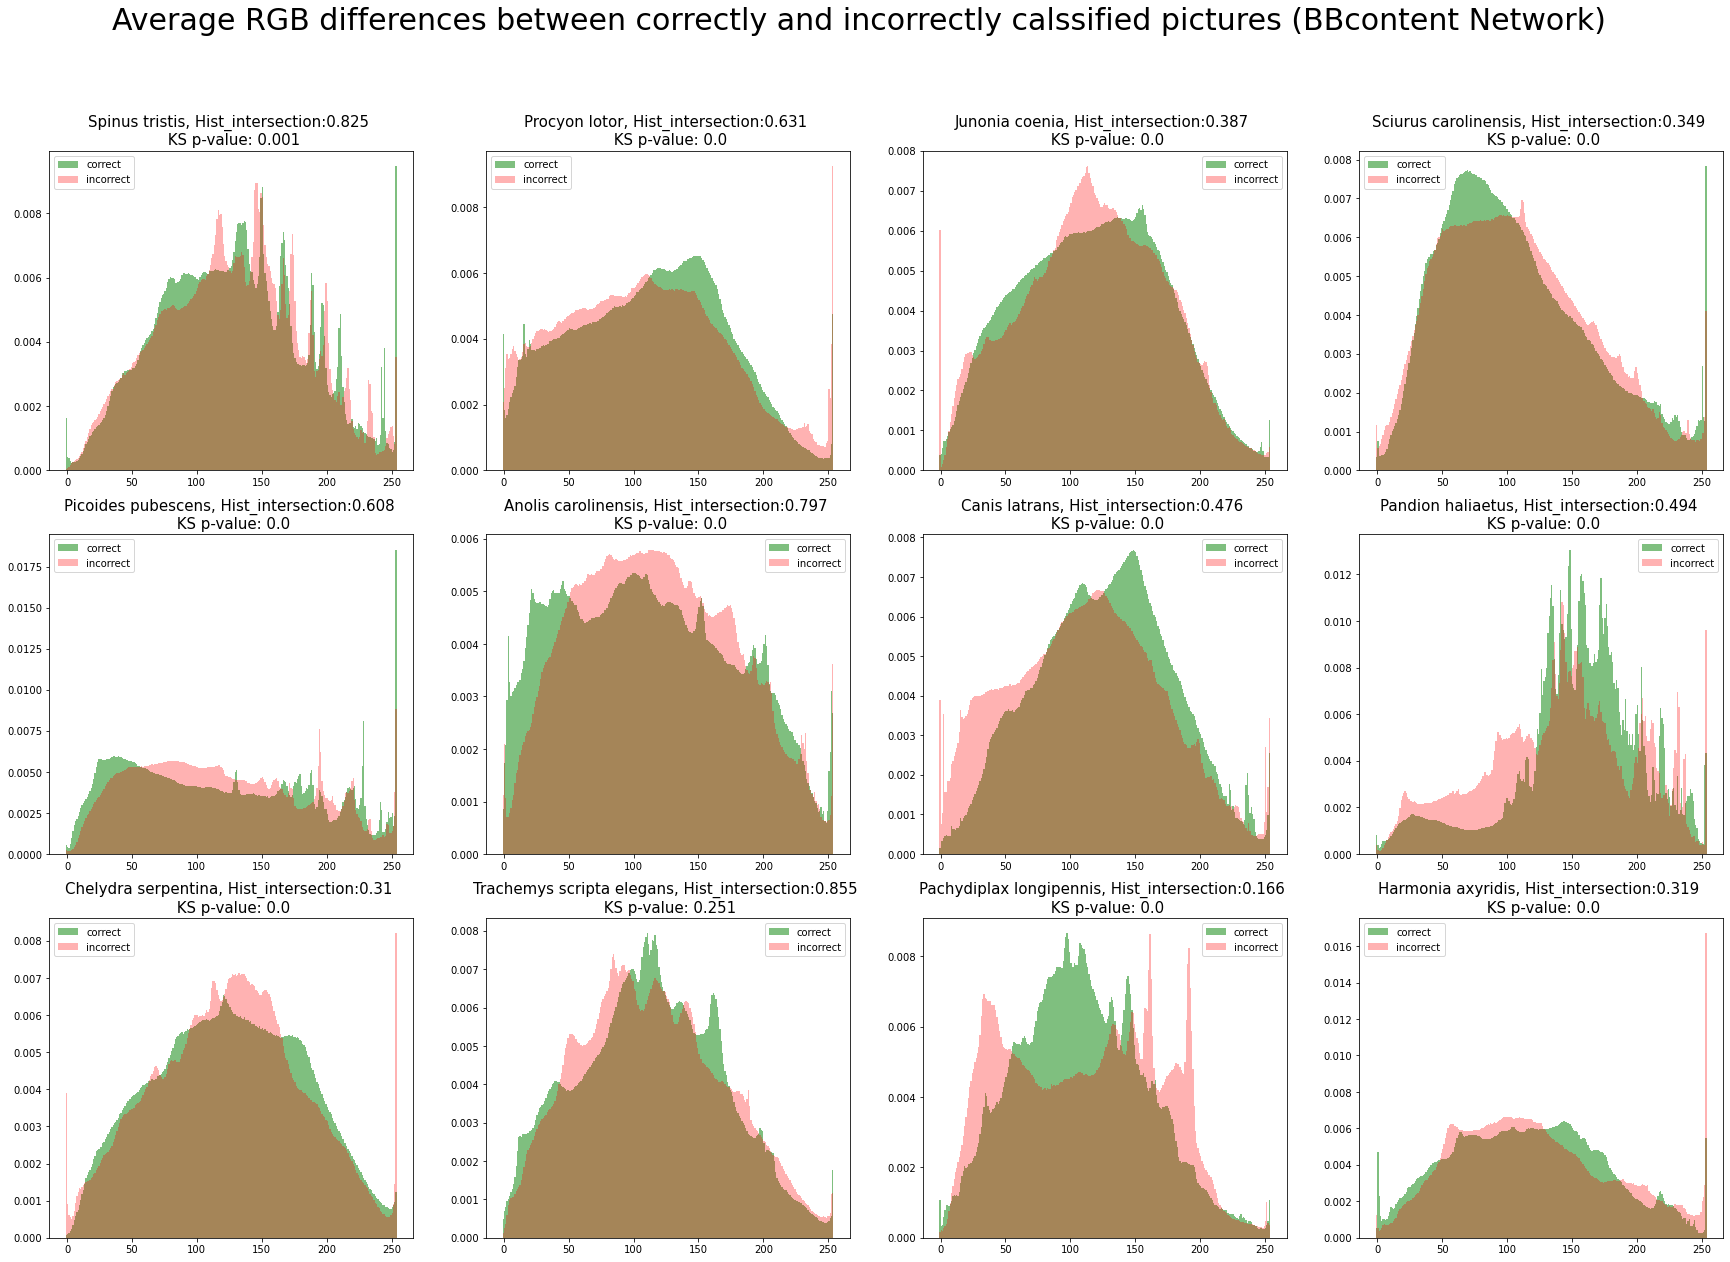

In [73]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize =(30,20))
axes = axes.ravel()
for ax, spec in zip(axes, species):
    ax.bar(bins[:-1] - 0.5, correct_dist_b[spec]/np.sum(correct_dist_b[spec]), width=1, color='green', label = 'correct', alpha = 0.5)
    ax.bar(bins[:-1] - 0.5, incorrect_dist_b[spec]/np.sum(incorrect_dist_b[spec]), width=1, color='red', label = 'incorrect', alpha = 0.3)
    kpval_b = round(kstest(correct_dist_b[spec],incorrect_dist_b[spec])[1], 3)
    ax.set_title(f'{spec}, Hist_intersection:{round(hist_int_b[spec], 3)} \n KS p-value: {kpval_b}', fontsize = 15)
    ax.legend()
    
fig.suptitle('Average RGB differences between correctly and incorrectly calssified pictures (BBcontent Network)', fontsize = 30)
plt.show()

In [74]:
# generating distributions for Mixed network
species = set(mixed['species'])
correct = mixed[mixed['misclassified']==0]
wrong = mixed[mixed['misclassified']==1]

correct_dist_mix, bins = generate_avgcolor_hist_dict(species, correct)
incorrect_dist_mix, bins = generate_avgcolor_hist_dict(species, wrong)

hist_int_mix = defaultdict(float)
for spec in species:
    hist_int_mix[spec]=histogram_intersection(correct_dist_mix[spec], incorrect_dist_mix[spec])

100%|██████████| 12/12 [00:49<00:00,  4.10s/it]


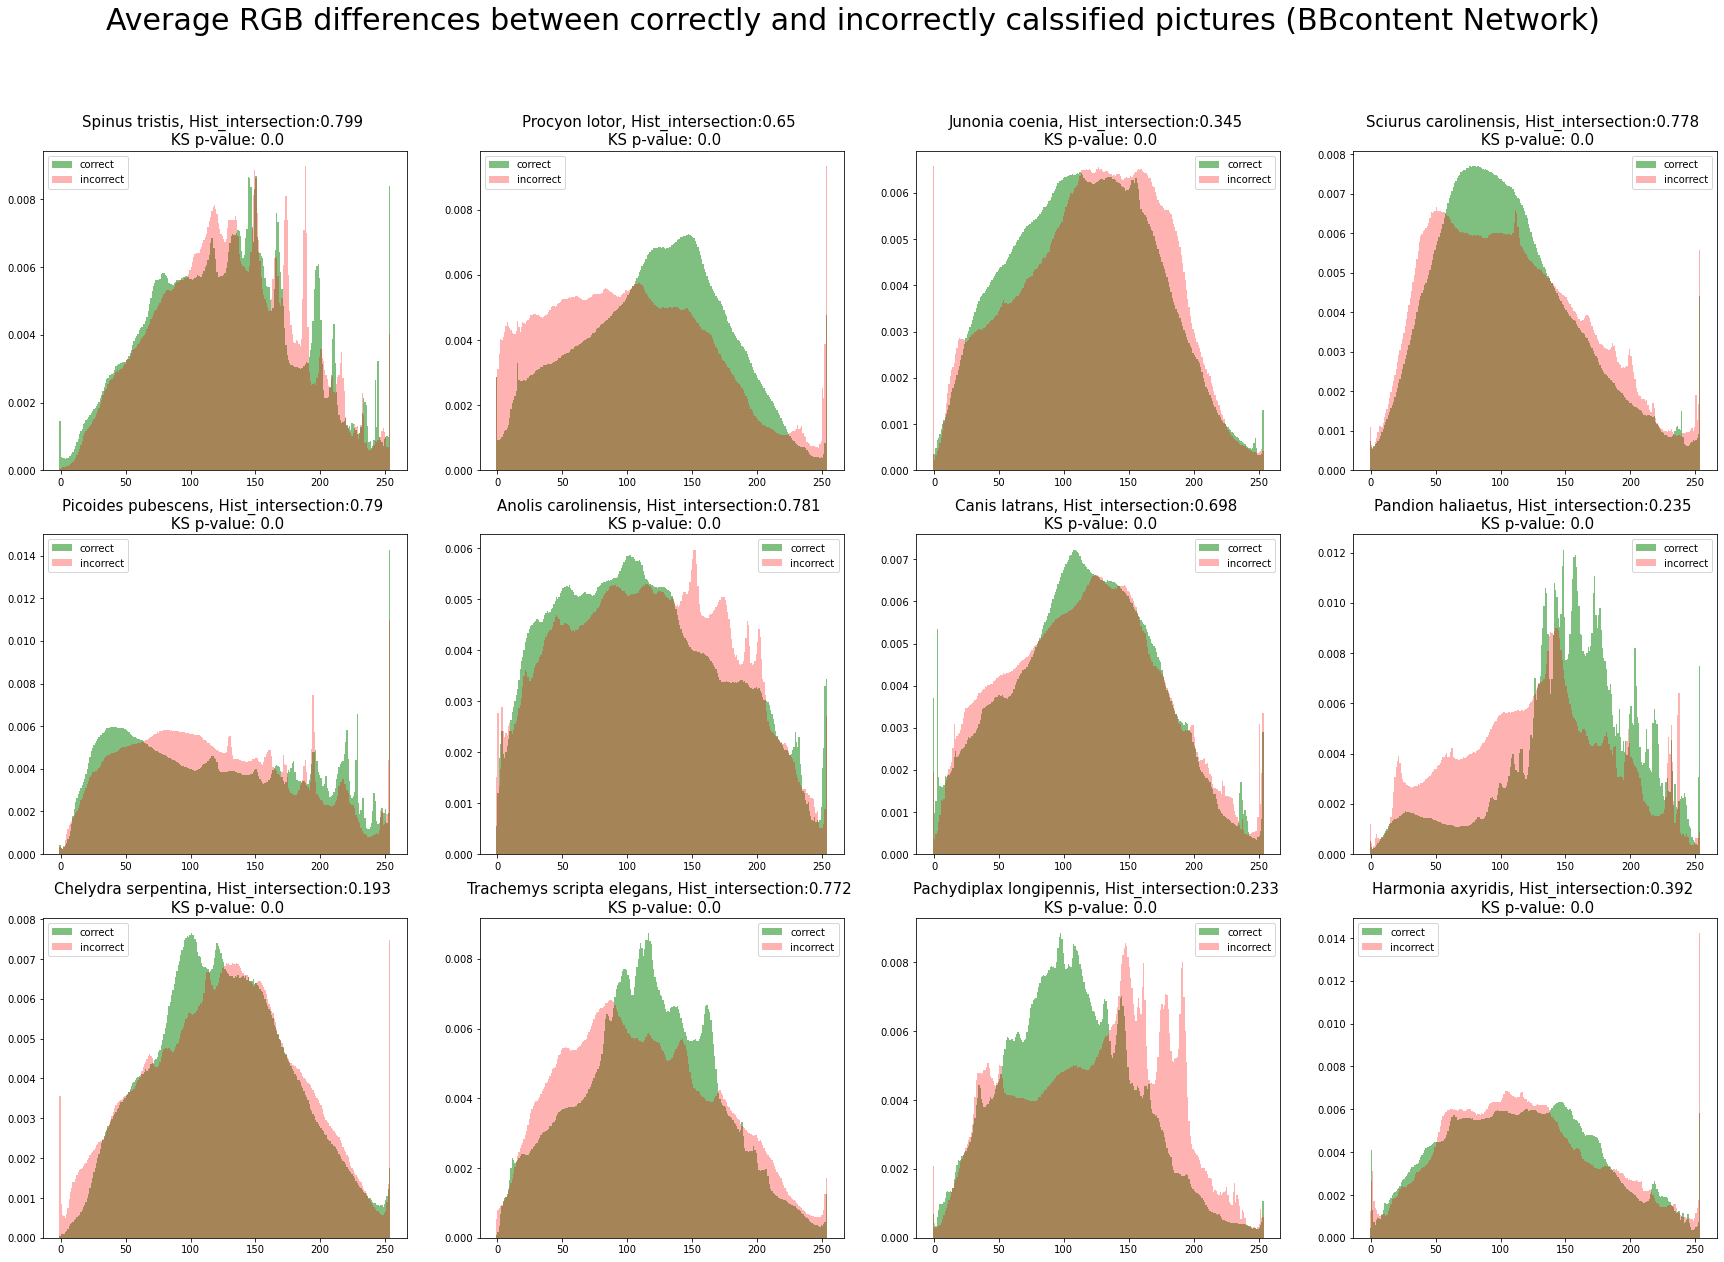

In [75]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize =(30,20))
axes = axes.ravel()
for ax, spec in zip(axes, species):
    ax.bar(bins[:-1] - 0.5, correct_dist_mix[spec]/np.sum(correct_dist_mix[spec]), width=1, color='green', label = 'correct', alpha = 0.5)
    ax.bar(bins[:-1] - 0.5, incorrect_dist_mix[spec]/np.sum(incorrect_dist_mix[spec]), width=1, color='red', label = 'incorrect', alpha = 0.3)
    kpval_b = round(kstest(correct_dist_mix[spec],incorrect_dist_mix[spec])[1], 3)
    ax.set_title(f'{spec}, Hist_intersection:{round(hist_int_mix[spec], 3)} \n KS p-value: {kpval_b}', fontsize = 15)
    ax.legend()
    
fig.suptitle('Average RGB differences between correctly and incorrectly calssified pictures (BBcontent Network)', fontsize = 30)
plt.show()

## Checking each color channel

In [44]:
# color mappings 'blue':0 'green':1 'red':2

def avg_chann_dist(df):
    
    dist_r = np.zeros((256, 1))
    dist_g = np.zeros((256, 1))
    dist_b = np.zeros((256, 1))
    count = 0
    for pic in tqdm(df['path']):
        for channel in range(3):
            img = cv2.imread(pic)
            histr = cv2.calcHist([img],[channel],None,[256],[0,256])
            if channel == 0:
                dist_b+=histr
            elif channel == 1:
                dist_g += histr
            else:
                dist_r += histr
        count+=1
    tot_dists = {'red':dist_r/count, 'green':dist_g/count, 'blue':dist_b/count}
    return tot_dists

    

In [45]:
#Vanilla model
correct = vanilla[vanilla['misclassified']==0]
wrong = vanilla[vanilla['misclassified']==1]

c_dists = avg_chann_dist(correct)
w_dists = avg_chann_dist(wrong)

100%|██████████| 1197/1197 [00:34<00:00, 34.81it/s]


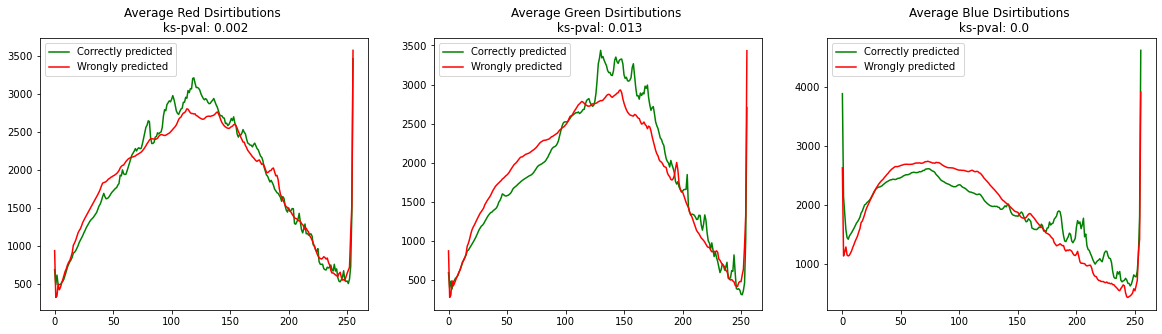

In [59]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,5))
ax = axes.ravel()

ax[0].plot(c_dists['red'], color = 'green', label = 'Correctly predicted')
ax[0].plot(w_dists['red'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists['red'].reshape(-1,),w_dists['red'].reshape(-1))[1], 3)
ax[0].set_title(f'Average Red Dsirtibutions \n ks-pval: {kpval}')
ax[0].legend()

ax[1].plot(c_dists['green'], color = 'green',label = 'Correctly predicted')
ax[1].plot(w_dists['green'], color = 'red',label = 'Wrongly predicted')
kpval = round(kstest(c_dists['green'].reshape(-1,),w_dists['green'].reshape(-1))[1], 3)
ax[1].set_title(f'Average Green Dsirtibutions \n ks-pval: {kpval}')
ax[1].legend()

ax[2].plot(c_dists['blue'], color = 'green',label = 'Correctly predicted')
ax[2].plot(w_dists['blue'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists['blue'].reshape(-1,),w_dists['blue'].reshape(-1))[1], 3)
ax[2].set_title(f'Average Blue Dsirtibutions \n ks-pval: {kpval}')
ax[2].legend()

plt.show()
    

In [61]:
#Masked model
correct = masked[masked['misclassified']==0]
wrong = masked[masked['misclassified']==1]

c_dists_m = avg_chann_dist(correct)
w_dists_m = avg_chann_dist(wrong)

100%|██████████| 1727/1727 [00:48<00:00, 35.36it/s]


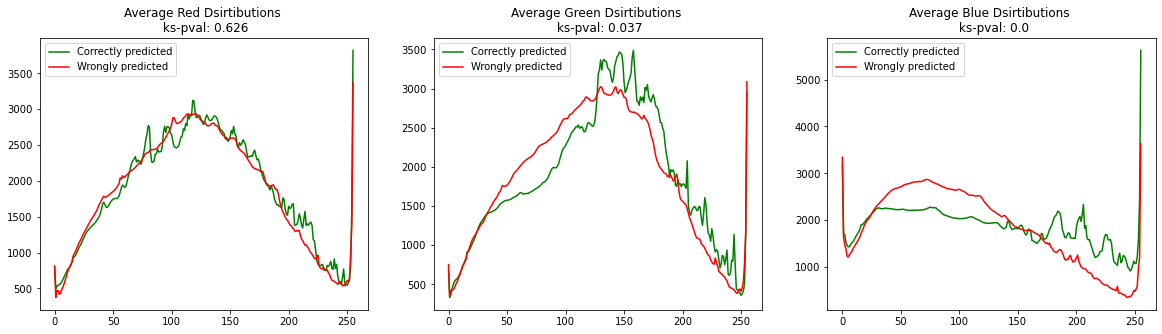

In [62]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,5))
ax = axes.ravel()

ax[0].plot(c_dists_m['red'], color = 'green', label = 'Correctly predicted')
ax[0].plot(w_dists_m['red'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists_m['red'].reshape(-1,),w_dists_m['red'].reshape(-1))[1], 3)
ax[0].set_title(f'Average Red Dsirtibutions \n ks-pval: {kpval}')
ax[0].legend()

ax[1].plot(c_dists_m['green'], color = 'green',label = 'Correctly predicted')
ax[1].plot(w_dists_m['green'], color = 'red',label = 'Wrongly predicted')
kpval = round(kstest(c_dists_m['green'].reshape(-1,),w_dists_m['green'].reshape(-1))[1], 3)
ax[1].set_title(f'Average Green Dsirtibutions \n ks-pval: {kpval}')
ax[1].legend()

ax[2].plot(c_dists_m['blue'], color = 'green',label = 'Correctly predicted')
ax[2].plot(w_dists_m['blue'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists_m['blue'].reshape(-1,),w_dists_m['blue'].reshape(-1))[1], 3)
ax[2].set_title(f'Average Blue Dsirtibutions \n ks-pval: {kpval}')
ax[2].legend()

plt.show()

In [63]:
#Bbcontent model
correct = bbcontent[bbcontent['misclassified']==0]
wrong = bbcontent[bbcontent['misclassified']==1]

c_dists_b = avg_chann_dist(correct)
w_dists_b = avg_chann_dist(wrong)

100%|██████████| 1242/1242 [00:35<00:00, 34.72it/s]


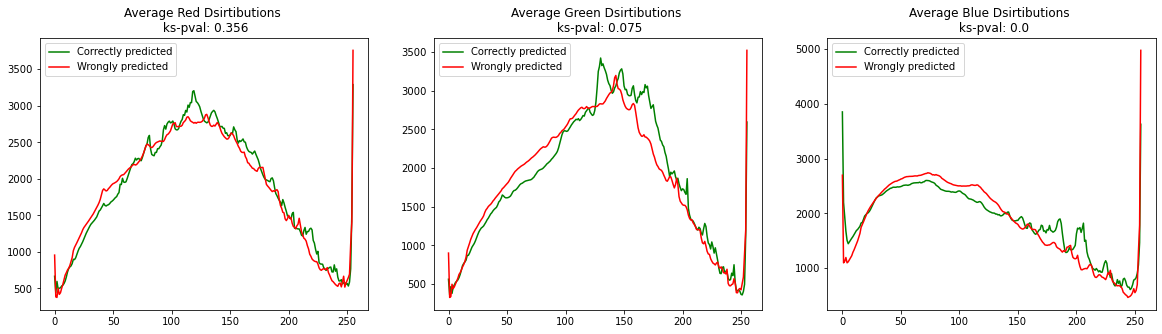

In [64]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,5))
ax = axes.ravel()

ax[0].plot(c_dists_b['red'], color = 'green', label = 'Correctly predicted')
ax[0].plot(w_dists_b['red'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists_b['red'].reshape(-1,),w_dists_b['red'].reshape(-1))[1], 3)
ax[0].set_title(f'Average Red Dsirtibutions \n ks-pval: {kpval}')
ax[0].legend()

ax[1].plot(c_dists_b['green'], color = 'green',label = 'Correctly predicted')
ax[1].plot(w_dists_b['green'], color = 'red',label = 'Wrongly predicted')
kpval = round(kstest(c_dists_b['green'].reshape(-1,),w_dists_b['green'].reshape(-1))[1], 3)
ax[1].set_title(f'Average Green Dsirtibutions \n ks-pval: {kpval}')
ax[1].legend()

ax[2].plot(c_dists_b['blue'], color = 'green',label = 'Correctly predicted')
ax[2].plot(w_dists_b['blue'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists_b['blue'].reshape(-1,),w_dists_b['blue'].reshape(-1))[1], 3)
ax[2].set_title(f'Average Blue Dsirtibutions \n ks-pval: {kpval}')
ax[2].legend()

plt.show()

In [65]:
#Mixed model
correct = mixed[mixed['misclassified']==0]
wrong = mixed[mixed['misclassified']==1]

c_dists_mix = avg_chann_dist(correct)
w_dists_mix = avg_chann_dist(wrong)

100%|██████████| 1119/1119 [00:32<00:00, 34.55it/s]


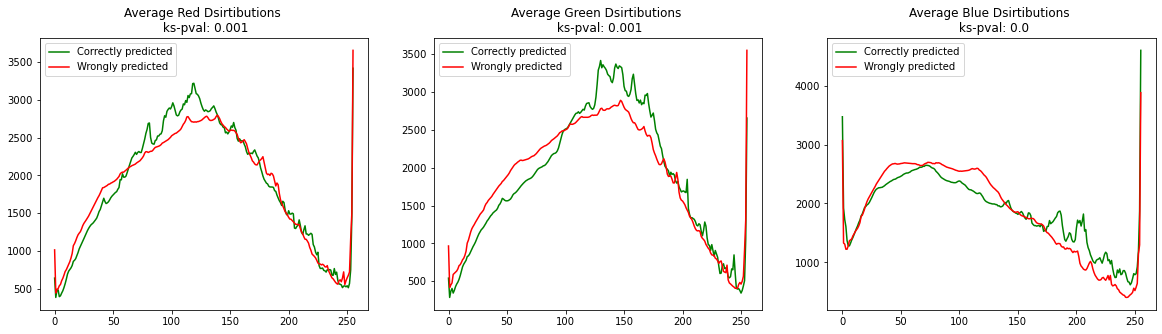

In [66]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,5))
ax = axes.ravel()

ax[0].plot(c_dists_mix['red'], color = 'green', label = 'Correctly predicted')
ax[0].plot(w_dists_mix['red'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists_mix['red'].reshape(-1,),w_dists_mix['red'].reshape(-1))[1], 3)
ax[0].set_title(f'Average Red Dsirtibutions \n ks-pval: {kpval}')
ax[0].legend()

ax[1].plot(c_dists_mix['green'], color = 'green',label = 'Correctly predicted')
ax[1].plot(w_dists_mix['green'], color = 'red',label = 'Wrongly predicted')
kpval = round(kstest(c_dists_mix['green'].reshape(-1,),w_dists_mix['green'].reshape(-1))[1], 3)
ax[1].set_title(f'Average Green Dsirtibutions \n ks-pval: {kpval}')
ax[1].legend()

ax[2].plot(c_dists_mix['blue'], color = 'green',label = 'Correctly predicted')
ax[2].plot(w_dists_mix['blue'], color = 'red', label = 'Wrongly predicted')
kpval = round(kstest(c_dists_mix['blue'].reshape(-1,),w_dists_mix['blue'].reshape(-1))[1], 3)
ax[2].set_title(f'Average Blue Dsirtibutions \n ks-pval: {kpval}')
ax[2].legend()

plt.show()

## Extracting average color per picture

In [87]:
def avg_color(df):
    
    avg_r = []
    avg_g = []
    avg_b = []
    for pic in tqdm(df['path']):
        img = cv2.imread(pic)
        red = np.mean(img[:,:,0])
        green = np.mean(img[:,:,1])
        blue = np.mean(img[:,:,2])
        avg_r.append(red)
        avg_g.append(green)
        avg_b.append(blue)
    diffs_r = np.array(avg_r)-np.mean(avg_r)
    diffs_g = np.array(avg_g)-np.mean(avg_g)
    diffs_b = np.array(avg_b)-np.mean(avg_b)
    tot_diffs= {'red':abs(diffs_r), 'green':abs(diffs_g), 'blue':abs(diffs_b)}
    return tot_diffs

In [88]:
colors = avg_color(vanilla)

100%|██████████| 2564/2564 [00:27<00:00, 93.84it/s] 


In [90]:
colors['red'][colors['red']<0]

array([], dtype=float64)

In [95]:
#Adding this data to the data we will use to run the logits
df = pd.read_csv('logit.csv')
df.head()

,misscl_masked,saturation,sift,contrast,bright,species,path,misscl_vanilla,misscl_bbcontent,misscl_mixed,family
0,0,122.619973,156,44.678057,122.619973,Pandion haliaetus,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,0,0,0,aves
1,1,80.271130,2784,76.915200,80.271130,Spinus tristis,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,0,0,0,aves
2,0,195.855005,330,96.223408,195.855005,Pachydiplax longipennis,Animals/Pachydiplax longipennis/c67ae3e186acb3...,0,0,0,insecta
3,1,46.955006,1671,92.882461,46.955006,Canis latrans,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,1,1,mammalia
4,1,85.638236,3032,84.739734,85.638236,Trachemys scripta elegans,Animals/Trachemys scripta elegans/fa1dd0961941...,0,1,1,reptilia


In [96]:
df['red'] = colors['red']
df['green'] = colors['green']
df['blue'] = colors['blue']
df.head()

,misscl_masked,saturation,sift,contrast,bright,species,path,misscl_vanilla,misscl_bbcontent,misscl_mixed,family,red,green,blue
0,0,122.619973,156,44.678057,122.619973,Pandion haliaetus,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,0,0,0,aves,75.529122,11.546985,28.336603
1,1,80.271130,2784,76.915200,80.271130,Spinus tristis,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,0,0,0,aves,11.764276,0.255391,0.093554
2,0,195.855005,330,96.223408,195.855005,Pachydiplax longipennis,Animals/Pachydiplax longipennis/c67ae3e186acb3...,0,0,0,insecta,50.937013,12.645696,16.546658
3,1,46.955006,1671,92.882461,46.955006,Canis latrans,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,1,1,mammalia,32.302684,5.813796,10.957970
4,1,85.638236,3032,84.739734,85.638236,Trachemys scripta elegans,Animals/Trachemys scripta elegans/fa1dd0961941...,0,1,1,reptilia,9.112623,1.590392,14.203597


In [97]:
df.to_csv('logit_final.csv')